* Librispeach clean (train 360h, test, dev)
* Common voice en (2 681h validated, train, test, dev)

In [1]:
import tarfile
import os

extract_dir = "data/extracted/"

for archive in os.listdir("data"):
    if archive.endswith(".gz"):
        archive = f"data/{archive}"
        try:
            with tarfile.open(archive, "r:gz") as tar:
                tar.extractall(path=extract_dir)
                print(f"{archive} extracted to: {extract_dir}")
        
        except Exception as e:
            print(f"Error: {e} extracting {archive}")

data/cv-corpus-20.0-2024-12-06-en.tar.gz extracted to: data/extracted/
data/test-clean.tar.gz extracted to: data/extracted/
data/train-clean-360.tar.gz extracted to: data/extracted/
data/dev-clean.tar.gz extracted to: data/extracted/


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import re

import tensorflow as tf

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

pd.options.display.float_format = '{:.2f}'.format

# CommonVoice

In [3]:
train_labels = pd.read_csv("data/extracted/cv-corpus-20.0-2024-12-06/en/train.tsv",
                           sep='\t',
                           usecols=["sentence", "path"])

def clean_transcription(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower() 

train_labels["clean_sentence"] = train_labels.sentence.apply(clean_transcription)
train_labels["num_characters"] = train_labels.clean_sentence.map(len)
    
train_labels

,path,sentence,clean_sentence,num_characters
0,common_voice_en_26405174.mp3,"There were coupe, sedan, and station wagon mod...",there were coupe sedan and station wagon model...,57
1,common_voice_en_26405176.mp3,His descendants and ideas would dominate class...,his descendants and ideas would dominate class...,91
2,common_voice_en_26405179.mp3,Or was it?,or was it,9
3,common_voice_en_649608.mp3,It’s just a few blocks to the North.,its just a few blocks to the north,34
4,common_voice_en_649610.mp3,I was never so tired in my life.,i was never so tired in my life,31
...,...,...,...,...
1124123,common_voice_en_40183465.mp3,The Woomera program never got out of planning ...,the woomera program never got out of planning ...,80
1124124,common_voice_en_40183478.mp3,He has six sons and a daughter.,he has six sons and a daughter,30
1124125,common_voice_en_40183482.mp3,The highway is named after a popular former Qu...,the highway is named after a popular former qu...,89
1124126,common_voice_en_40183486.mp3,"An adjoining conservation area, Eastcote Park,...",an adjoining conservation area eastcote park i...,91


In [4]:
train_labels[["num_characters"]].describe(percentiles=[0.99])

,num_characters
count,1124128.00
mean,60.65
std,32.50
min,2.00
50%,61.00
99%,100.00
max,15083.00


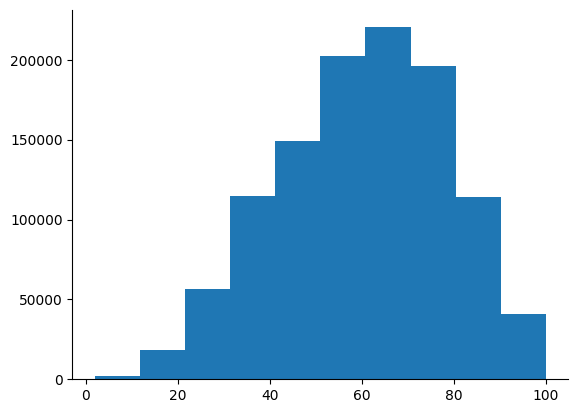

In [9]:
threshold = train_labels.num_characters.quantile(0.99)
idxs = np.where(train_labels.num_characters > threshold)[0].tolist()
train_labels.drop(idxs, inplace=True)

plt.hist(train_labels.num_characters);

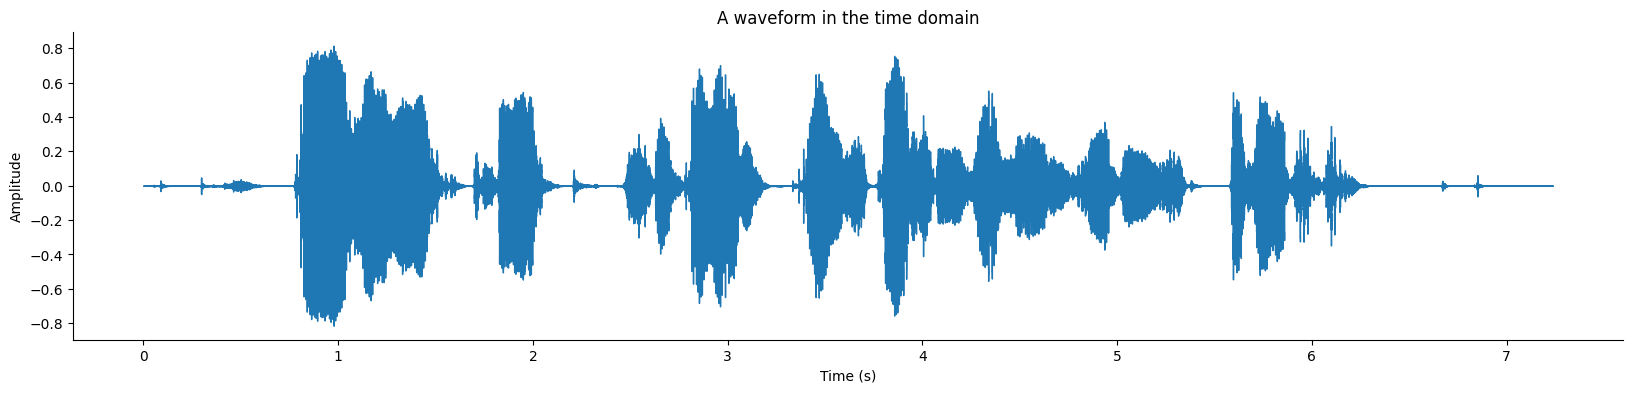

MFCC size: (13, 227)


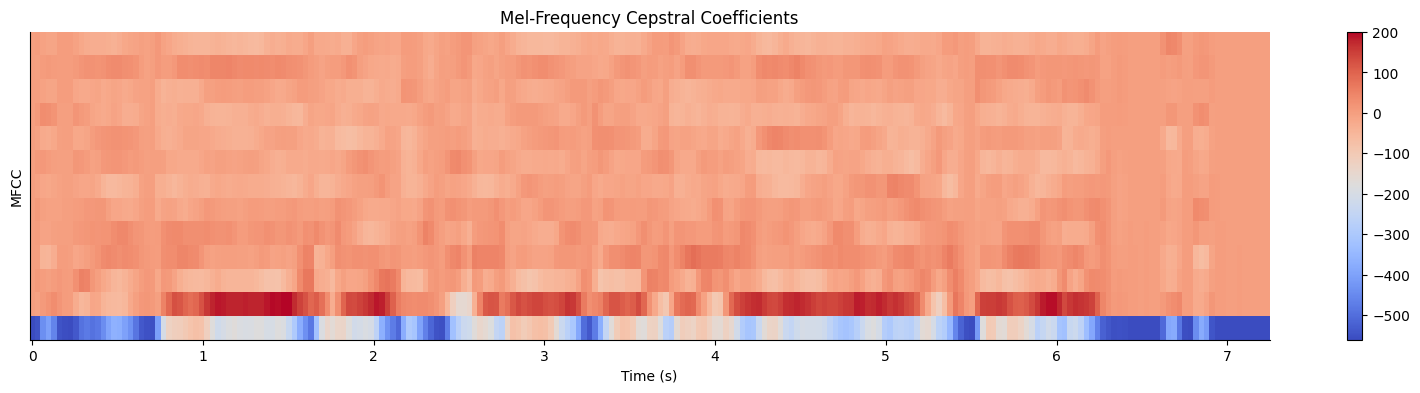

Label:
there were coupe sedan and station wagon models available
Encoded label:
[20, 8, 5, 18, 5, 27, 23, 5, 18, 5, 27, 3, 15, 21, 16, 5, 27, 19, 5, 4, 1, 14, 27, 1, 14, 4, 27, 19, 20, 1, 20, 9, 15, 14, 27, 23, 1, 7, 15, 14, 27, 13, 15, 4, 5, 12, 19, 27, 1, 22, 1, 9, 12, 1, 2, 12, 5] 

Data shape: (1, 227, 13)
Label shape: (1, 100) 

<_TensorSliceDataset element_spec=(TensorSpec(shape=(227, 13), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>
tf.Tensor(
[[-5.6119305e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.4784357e+02 -5.4666700e+00  9.5127411e+00 ... -2.0923561e-01
  -2.8514884e+00  4.1936822e+00]
 [-4.3956561e+02  7.2210236e+00  1.7580926e+00 ... -6.7666922e+00
   6.1537137e+00 -5.5324597e+00]
 ...
 [-5.6095575e+02  3.3235824e-01  3.2263875e-01 ...  5.9433773e-02
   1.3236031e-02 -3.3126295e-02]
 [-5.6119305e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.6

In [21]:
audio_files_dir = "data/extracted/cv-corpus-20.0-2024-12-06/en/clips/"
char_to_num = {char: idx + 1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
char_to_num['<PAD>'] = 0
n_mfcc = 13
max_label = 100

for sample in train_labels[:1].itertuples():

    # data
    audio_file_path = f'{audio_files_dir}{sample.path}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)

    plt.figure(figsize=(20, 4))
    librosa.display.waveshow(audio_time_series, sr=sample_rate)
    plt.title("A waveform in the time domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # mfcc extraction
    mfcc = librosa.feature.mfcc(y=audio_time_series, sr=sample_rate, n_mfcc=n_mfcc)
    print(f"MFCC size: {mfcc.shape}")
    
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title("Mel-Frequency Cepstral Coefficients")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC")
    plt.show()

    # label
    encoded_text = [char_to_num[char] for char in sample.clean_sentence]
    
    print("Label:")
    print(sample.clean_sentence)
    print("Encoded label:")
    print(encoded_text, "\n")

    # creating dataset
    padded_labels = np.pad(encoded_text,
                           (0, max_label - len(encoded_text)),
                           constant_values=char_to_num["<PAD>"])
    X_train = tf.expand_dims(mfccs.T, axis=0)
    y_train = tf.expand_dims(padded_labels, axis=0)
    print("Data shape:", X_train.shape)
    print("Label shape:", y_train.shape, "\n")

    data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    print(data)
    for t, l in data.take(1):
        print(t, l)